In [1]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2 as cv
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
!git clone https://github.com/cardstdani/WasteClassificationNeuralNetwork.git

Cloning into 'WasteClassificationNeuralNetwork'...
remote: Enumerating objects: 5092, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 5092 (delta 10), reused 23 (delta 9), pack-reused 5068
Receiving objects: 100% (5092/5092), 223.89 MiB | 16.49 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Checking out files: 100% (5082/5082), done.


In [4]:
#LOAD DATA
DIR = "/content/WasteClassificationNeuralNetwork/WasteImagesDataset"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))

classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 5078 files belonging to 9 classes.
Using 4571 files for training.
Found 5078 files belonging to 9 classes.
Using 507 files for validation.
['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']


In [5]:
baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256,3), weights='imagenet', include_top=False, classes=numClasses)
for layers in baseModel.layers[:-6]:
  layers.trainable=False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.45) (last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.045), activity_regularizer=tf.keras.regularizers.l1(0.045),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input,outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs = 50
lrCallback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 30))
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[])

12697600/12683000 [==============================] - 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


36/36 [==============================] - 36s 448ms/step - loss: 242.5795 - accuracy: 0.5806 - val_loss: 101.4837 - val_accuracy: 0.8146
Epoch 2/50
36/36 [==============================] - 16s 366ms/step - loss: 45.0226 - accuracy: 0.7823 - val_loss: 11.1791 - val_accuracy: 0.6568
Epoch 3/50
36/36 [==============================] - 17s 395ms/step - loss: 6.4504 - accuracy: 0.5539 - val_loss: 4.4148 - val_accuracy: 0.5207
Epoch 4/50
36/36 [==============================] - 16s 365ms/step - loss: 4.1680 - accuracy: 0.5301 - val_loss: 4.0203 - val_accuracy: 0.5207
Epoch 5/50
36/36 [==============================] - 16s 369ms/step - loss: 4.0295 - accuracy: 0.5246 - val_loss: 3.9414 - val_accuracy: 0.5385
Epoch 6/50
36/36 [==============================] - 16s 369ms/step - loss: 3.9746 - accuracy: 0.5419 - val_loss: 3.8442 - val_accuracy: 0.5247
Epoch 7/50
36/36 [==============================] - 16s 367ms/step - loss: 3.9016 - accuracy: 0.5447 - val_loss: 3.7872 - val_accuracy: 0.5128
Epoc

In [6]:
model.save("/content/model.h5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 128, 128, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

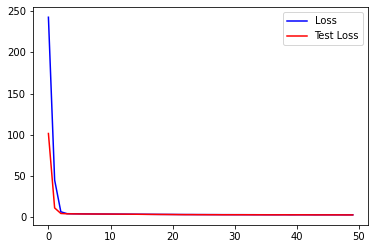

In [7]:
plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
plt.legend()
plt.show()

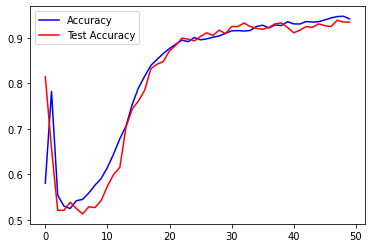

In [8]:
plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.legend()
plt.show()

Text(0, 0.5, 'Loss')

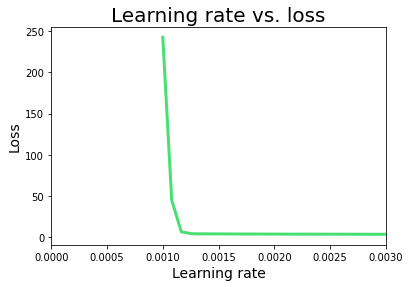

In [9]:
plt.xlim([0, 0.003])
learning_rates = 1e-3 * (10 ** (np.arange(epochs) / 30))
plt.plot(learning_rates, history.history['loss'], lw=3, color='#48e073')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)

[ 1.0254012 10.181613   1.6603261  1.6446027 74.30235    2.1784701
  1.8819941  4.4671764  2.6580696] 
 ['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']
Prediction:  Other Plastics 74.30235147476196%


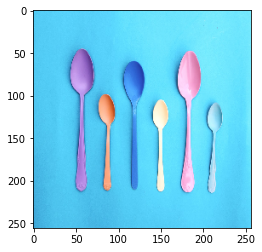

In [10]:
import requests

img_data = requests.get("https://images.unsplash.com/photo-1591872203534-278fc084969e?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1064&q=80").content
with open('img.jpg', 'wb') as handler:
    handler.write(img_data)

path = "/content/img.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")